In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Generate sample Markowitz bullet

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


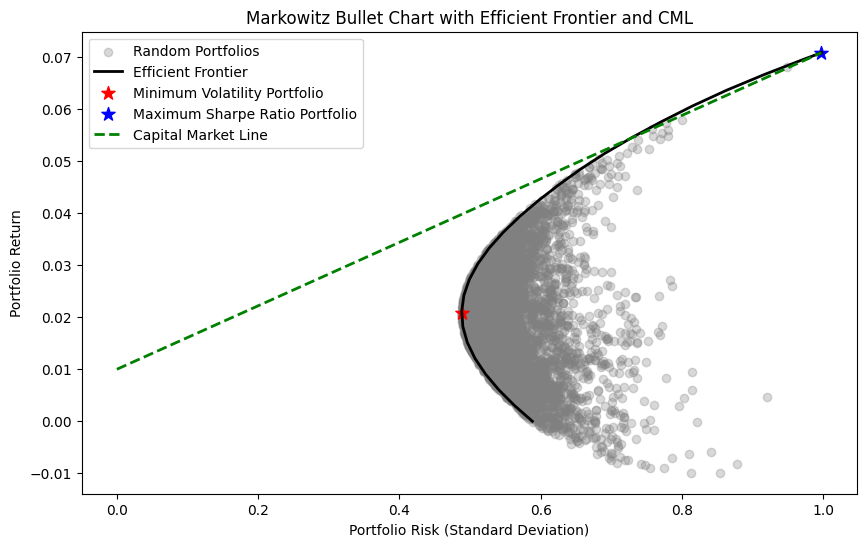

In [4]:
# Generate sample returns data for 4 assets
np.random.seed(42)
n_assets = 4
n_obs = 1000
return_vec = np.random.randn(n_assets, n_obs)

# Calculate mean returns and covariance matrix
mean_returns = np.mean(return_vec, axis=1)
cov_matrix = np.cov(return_vec)

# Function to calculate portfolio statistics
def portfolio_stats(weights, mean_returns, cov_matrix):
    port_return = np.sum(mean_returns * weights)
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_std

# Function to minimize (negative Sharpe ratio)
def min_func_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0):
    p_returns, p_std = portfolio_stats(weights, mean_returns, cov_matrix)
    return -((p_returns - risk_free_rate) / p_std)

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(n_assets))

# Generate random portfolios
n_portfolios = 5000
results = np.zeros((3, n_portfolios))
for i in range(n_portfolios):
    weights = np.random.random(n_assets)
    weights /= np.sum(weights)
    portfolio_return, portfolio_std = portfolio_stats(weights, mean_returns, cov_matrix)
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std
    results[2,i] = results[0,i] / results[1,i]  # Sharpe ratio

# Optimize for the minimum volatility portfolio
min_vol_result = minimize(lambda x: portfolio_stats(x, mean_returns, cov_matrix)[1], 
                          n_assets*[1./n_assets,], method='SLSQP', bounds=bounds, constraints=constraints)

# Efficient frontier
target_returns = np.linspace(0.0, 0.3, 100)
efficient_portfolios = []
for target in target_returns:
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_stats(x, mean_returns, cov_matrix)[0] - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = minimize(lambda x: portfolio_stats(x, mean_returns, cov_matrix)[1], 
                      n_assets*[1./n_assets,], method='SLSQP', bounds=bounds, constraints=constraints)
    efficient_portfolios.append(result)

# Risk-free rate
risk_free_rate = 0.01

# Maximum Sharpe ratio portfolio
max_sharpe_result = minimize(min_func_sharpe, n_assets*[1./n_assets,], args=(mean_returns, cov_matrix, risk_free_rate),
                             method='SLSQP', bounds=bounds, constraints=constraints)

# Plot
plt.figure(figsize=(10, 6))

# Plot random portfolios
plt.scatter(results[1,:], results[0,:], c='gray', marker='o', alpha=0.3, label='Random Portfolios')

# Plot efficient frontier
eff_returns = [portfolio_stats(x.x, mean_returns, cov_matrix)[0] for x in efficient_portfolios]
eff_stds = [portfolio_stats(x.x, mean_returns, cov_matrix)[1] for x in efficient_portfolios]
plt.plot(eff_stds, eff_returns, 'black', lw=2, label='Efficient Frontier')

# Plot minimum volatility portfolio
min_vol_return, min_vol_std = portfolio_stats(min_vol_result.x, mean_returns, cov_matrix)
plt.scatter(min_vol_std, min_vol_return, color='red', marker='*', s=100, label='Minimum Volatility Portfolio')

# Plot maximum Sharpe ratio portfolio
max_sharpe_return, max_sharpe_std = portfolio_stats(max_sharpe_result.x, mean_returns, cov_matrix)
plt.scatter(max_sharpe_std, max_sharpe_return, color='blue', marker='*', s=100, label='Maximum Sharpe Ratio Portfolio')

# Plot CML
cml_x = [0, max_sharpe_std]
cml_y = [risk_free_rate, max_sharpe_return]
plt.plot(cml_x, cml_y, color='green', lw=2, linestyle='--', label='Capital Market Line')

plt.title('Markowitz Bullet Chart with Efficient Frontier and CML')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.legend(loc='upper left')

# Save to EPS format
plt.savefig('../charts/markowitz_bullet_chart_with_cml.eps', format='eps')
plt.show()
